In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import rrg_toolkit as rrg
def get_drawdown(p):
    """
    计算净值回撤
    """
    T = len(p)
    hmax = [p[0]]
    for t in range(1, T):
        hmax.append(np.nanmax([p[t], hmax[t - 1]]))
    dd = [p[t] / hmax[t] - 1 for t in range(T)]

    return dd


def cal_period_perf_indicator(adjnav):
    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])
        for col in res.columns:
            if col=='SR':continue
            res[col] = res[col].apply(float_to_percent)
        return res
    ret = adjnav.pct_change()
    annret = (adjnav[-1] / adjnav[0]) ** (242/len(adjnav)) - 1 # 复利
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd

    return [annret, annvol, sr, mdd, calmar]

def datestr2dtdate(datestr):
    # 日期格式转换：'yyyy-mm-dd'转为datetime.date
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()

# Define a formatting function to convert float to percentage
def float_to_percent(x):
    return "{:.0%}".format(x)

def date_count_in_month(dates):
    # 计算日期序列中每个日期在所在月中的序数
    cur_count = 1
    counts = [cur_count]
    for i in range(1,len(dates)):
        if dates[i].month == dates[i-1].month:
            cur_count = cur_count + 1
        else:
            cur_count = 1
        counts.append(cur_count)
    return counts


# RRG

In [2]:
# Prepare RRG Matrix
prices = pd.read_csv('../Data/USD ETFs_open.csv')
prices = prices.set_index('datetime')
prices.index = [datestr2dtdate(e) for e in prices.index]

,AnnRet,AnnVol,SR,MaxDD,Calmar
SPY,27%,16%,1.722952,-8%,337%
SCHE,4%,14%,0.268243,-12%,33%
stgy,34%,14%,2.461748,-6%,575%


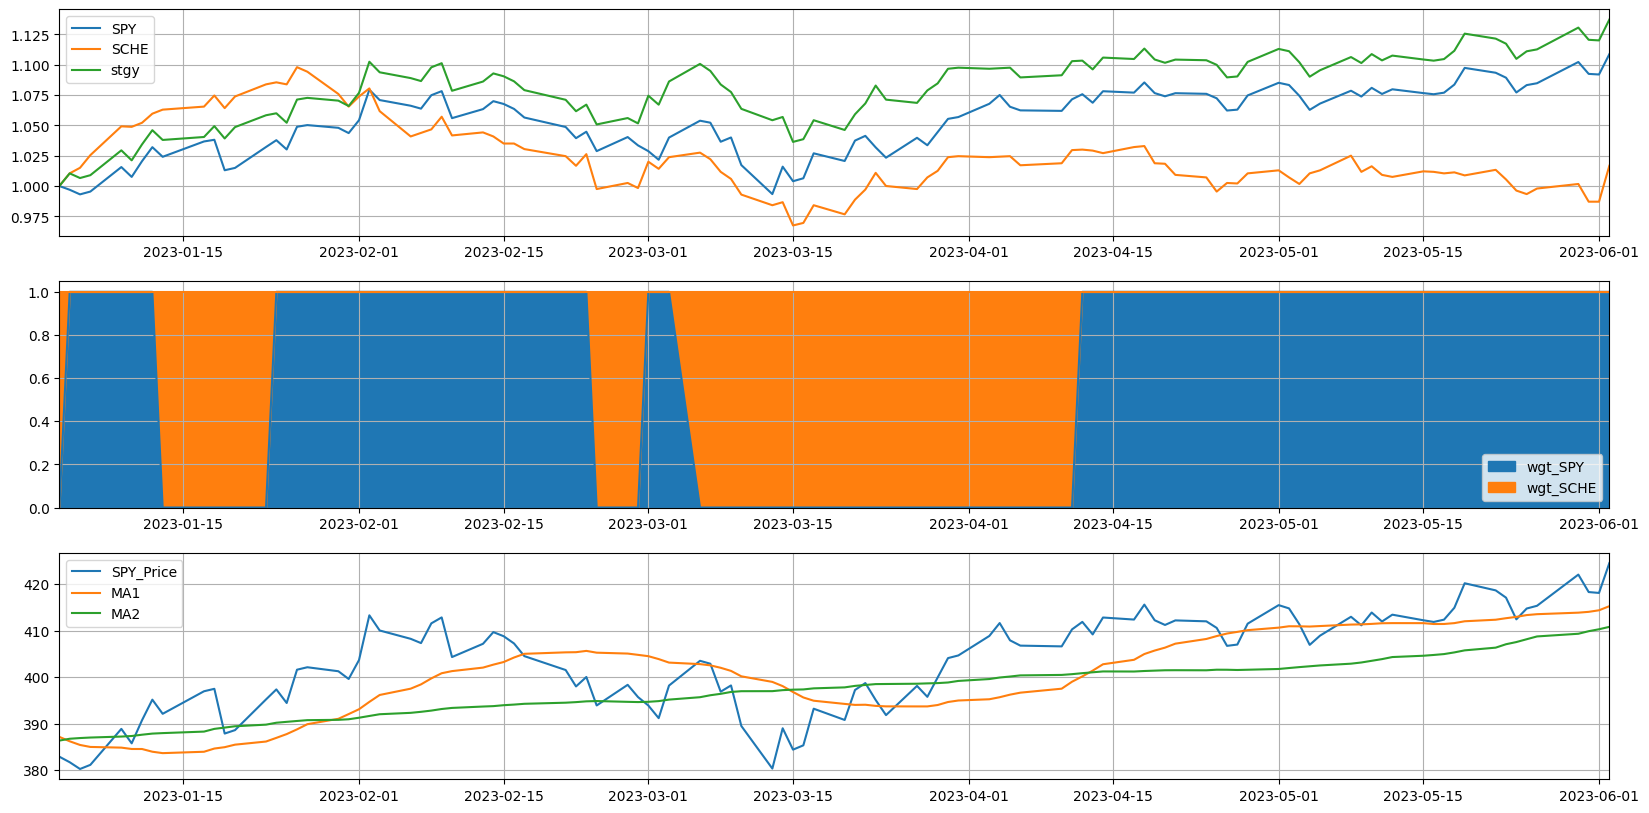

In [58]:
# Rotation with RRG Signal
ETF1 = 'SPY'
ETF2 = 'SCHE'
weight = 1
start_date = datetime.date(2023,1,1)
df = prices[[ETF1,ETF2]].copy()

df['rs_ratio'] = df[ETF2] / df[ETF1]
df['jdk_rs_ratio'] = rrg.calc_jdk_rs_ratio(df[['rs_ratio']])
df['jdk_rs_momentum'] = rrg.calc_jdk_rs_momentum(df[['jdk_rs_ratio']])
df['jdk_rs_ratio_lag'] = df['jdk_rs_ratio'].shift(5)
df['jdk_rs_momentum_lag'] = df['jdk_rs_momentum'].shift(5)

df['MA1'] = df[ETF1].rolling(window=20).mean()
df['MA2'] = df[ETF1].rolling(window=50).mean()
df = df[df.index>start_date]
df[f'ret_{ETF1}'] = df[ETF1].pct_change()
df[f'ret_{ETF2}'] = df[ETF2].pct_change()
def strategy(df):
    global wieght
    df[f'wgt_{ETF1}'] = weight
    df[f'wgt_{ETF2}'] = 1 - weight
    # set up Rules when choose SCHE
    area = rrg.categorize_point(df['jdk_rs_ratio'],df['jdk_rs_momentum'])
    area_lag = rrg.categorize_point(df['jdk_rs_ratio_lag'],df['jdk_rs_momentum_lag'])
    slope = rrg.calculate_slope(df['jdk_rs_ratio'],df['jdk_rs_momentum'],df['jdk_rs_ratio_lag'],df['jdk_rs_momentum_lag'])
    radius = rrg.categorize_radius(df['jdk_rs_ratio'],df['jdk_rs_momentum'],0.01)

    if slope > 0.8 and radius=='Strong': # and area in ['Leading','Improving']
        df[f'wgt_{ETF2}'] = weight
        df[f'wgt_{ETF1}'] = 1 - weight
    # Cash Out Logic
    # ma = df[ETF1] / df['MA1']
    # if (ma < 0.95 or ma > 1.05 ) and df[f'wgt_{ETF1}']==weight:
    #     df[f'wgt_{ETF1}'] = 0
    #     df[f'wgt_{ETF2}'] = 0
    return df
df = df.apply(strategy,axis=1)
df[f'{ETF1}_Price'] = df[f'{ETF1}'] 
df[f'{ETF2}_Price'] = df[f'{ETF2}'] 

df['ret_stgy'] = df[f'ret_{ETF1}'] * df[f'wgt_{ETF1}'].shift(1) + df[f'ret_{ETF2}'] * df[f'wgt_{ETF2}'].shift(1)
df[ETF1] = (1+df[f'ret_{ETF1}']).cumprod().fillna(1)
df[ETF2] = (1+df[f'ret_{ETF2}']).cumprod().fillna(1)
df['stgy'] = (1+df['ret_stgy']).cumprod().fillna(1)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(3,1,1)
df.loc[:,[ETF1, ETF2, 'stgy']].plot(ax=ax1, grid=True)
plt.xlim(df.index[0],df.index[-1])

ax2 = fig.add_subplot(3,1,2)
df[[f'wgt_{ETF1}', f'wgt_{ETF2}']].plot(ax=ax2, kind='area', stacked=True, grid=True)
plt.xlim(df.index[0],df.index[-1])

ax3 = fig.add_subplot(3,1,3)
df[[f'{ETF1}_Price','MA1','MA2']].plot(ax=ax3, grid=True)
plt.xlim(df.index[0],df.index[-1])    

res = cal_period_perf_indicator(df.loc[:,[ETF1, ETF2, 'stgy']])
res



## RRG with multiple asset

In [73]:
# Rotation with RRG Signal
benchmark = 'SPY'
start_date = datetime.date(2022,1,1)
data = prices.copy()

def RRG_Multi(data,start_date,params={'benchmark':benchmark,'N':5}):
    target_wgt = pd.DataFrame(0, index=data.index, columns=data.columns)
    df = data.copy()
    benchmark = params['benchmark']
    N = params['N']
    # RRG Variable
    df = rrg.calculate_rs_ratios(df,benchmark)
    jdk_rs_ratio = pd.DataFrame(0, index=df.index, columns=df.columns)
    jdk_rs_momentum = pd.DataFrame(0, index=df.index, columns=df.columns)
    for i in jdk_rs_ratio.columns:
        jdk_rs_ratio[i] = rrg.calc_jdk_rs_ratio(df[i])
        jdk_rs_momentum[i] = rrg.calc_jdk_rs_momentum(jdk_rs_ratio[i])
    
    # RRG Derived
    # Calculate the distance
    distance = np.sqrt( jdk_rs_ratio ** 2 + jdk_rs_momentum ** 2 )
    distance = pd.DataFrame(distance, index=df.index, columns=df.columns)

    # Determine the quadrant
    quadrant = np.empty_like(df)
    quadrant[(jdk_rs_ratio > 0) & (jdk_rs_momentum > 0)] = 1
    quadrant[(jdk_rs_ratio > 0) & (jdk_rs_momentum < 0)] = 2
    quadrant[(jdk_rs_ratio < 0) & (jdk_rs_momentum < 0)] = 3
    quadrant[(jdk_rs_ratio < 0) & (jdk_rs_momentum > 0)] = 4
    quadrant = pd.DataFrame(quadrant, index=df.index, columns=df.columns)
    quadrant = quadrant.replace(1,'Leading').replace(2,'Weakening').replace(3,'Lagging').replace(4,'Improving')

    # Trend
    trend_x = jdk_rs_ratio / jdk_rs_ratio.shift(N) - 1 
    trend_y = jdk_rs_momentum / jdk_rs_momentum.shift(N) - 1 
    

    return target_wgt
RRG_Multi(data,start_date)


,ARKK,BND,EEM,EFA,FXI,GLD,GOVT,HYG,IJH,IWM,...,VTI,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
2010-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-05-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-05-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-06-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
